### **Student Information**
Name: 黃晨溦

Student ID: 112024803

GitHub ID: huang-chen-wei

Kaggle name: lotiaus

Kaggle private scoreboard snapshot: 

![leaderboard.png](./pics/leaderboard.png)

---

# **Instructions**

For this lab we have divided the assignments into **three phases/parts**. The `first two phases` refer to the `exercises inside the Master notebooks` of the [DM2025-Lab2-Exercise Repo](https://github.com/difersalest/DM2025-Lab2-Exercise.git). The `third phase` refers to an `internal Kaggle competition` that we are gonna run among all the Data Mining students. Together they add up to `100 points` of your grade. There are also some `bonus points` to be gained if you complete `extra exercises` in the lab **(bonus 15 pts)** and in the `Kaggle Competition report` **(bonus 5 pts)**.

**Environment recommendations to solve lab 2:**
- **Phase 1 exercises:** Need GPU for training the models explained in that part, if you don't have a GPU in your laptop it is recommended to run in Colab or Kaggle for a faster experience, although with CPU they can still be solved but with a slower execution.
- **Phase 2 exercises:** We use Gemini's API so everything can be run with only CPU without a problem.
- **Phase 3 exercises:** For the competition you will probably need GPU to train your models, so it is recommended to use Colab or Kaggle if you don't have a laptop with a dedicated GPU.
- **Optional Ollama Notebook (not graded):** You need GPU, at least 4GB of VRAM with 16 GB of RAM to run the local open-source LLM models. 

## **Phase 1 (30 pts):**

1. __Main Exercises (25 pts):__ Do the **take home exercises** from Sections: `1. Data Preparation` to `9. High-dimension Visualization: t-SNE and UMAP`, in the [DM2025-Lab2-Master-Phase_1 Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_1.ipynb). Total: `8 exercises`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 3th, 11:59 pm, Monday)`**

2. **Code Comments (5 pts):** **Tidy up the code in your notebook**. 

## **Phase 2 (30 pts):**

1. **Main Exercises (25 pts):** Do the remaining **take home exercises** from Section: `2. Large Language Models (LLMs)` in the [DM2025-Lab2-Master-Phase_2_Main Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Main.ipynb). Total: `5 exercises required from sections 2.1, 2.2, 2.4 and 2.6`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**

2. **Code Comments (5 pts):** **Tidy up the code in your notebook**. 

3. **`Bonus (15 pts):`** Complete the bonus exercises in the [DM2025-Lab2-Master-Phase_2_Bonus Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Bonus.ipynb) and [DM2025-Lab2-Master-Phase_2_Main Notebook](https://github.com/difersalest/DM2025-Lab2-Exercise/blob/main/DM2025-Lab2-Master-Phase_2_Main.ipynb) `where 2 exercises are counted as bonus from sections 2.3 and 2.5 in the main notebook`. Total: `7 exercises`. Commit your code and submit the repository link to NTU Cool **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**

## **Phase 3 (40 pts):**

1. **Kaggle Competition Participation (30 pts):** Participate in the in-class **Kaggle Competition** regarding Emotion Recognition on Twitter by clicking in this link: **[Data Mining Class Kaggle Competition](https://www.kaggle.com/t/3a2df4c6d6b4417e8bf718ed648d7554)**. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20 pts of the 30 pts in this competition participation part.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **`BEFORE the deadline (Nov. 24th, 11:59 pm, Monday)`**. Make sure to take a screenshot of your position at the end of the competition and store it as `pic_ranking.png` under the `pics` folder of this repository and rerun the cell **Student Information**.

2. **Competition Report (10 pts)** A report section to be filled in inside this notebook in Markdown Format, we already provided you with the template below. You need to describe your work developing the model for the competition. The report should include a section describing briefly the following elements: 
* Your preprocessing steps.
* The feature engineering steps.
* Explanation of your model.

* **`Bonus (5 pts):`**
    * You will have to describe more detail in the previous steps.
    * Mention different things you tried.
    * Mention insights you gained. 

[Markdown Guide - Basic Syntax](https://www.markdownguide.org/basic-syntax/)

**`Things to note for Phase 3:`**

* **The code used for the competition should be in this Jupyter Notebook File** `DM2025-Lab2-Homework.ipynb`.

* **Push the code used for the competition to your repository**.

* **The code should have a clear separation for the same sections of the report, preprocessing, feature engineering and model explanation. Briefly comment your code for easier understanding, we provide a template at the end of this notebook.**

* Showing the kaggle screenshot of the ranking plus the code in this notebook will ensure the validity of your participation and the report to obtain the corresponding points.

After the competition ends you will have two days more to submit the `DM2025-Lab2-Homework.ipynb` with your report in markdown format and your code. Do everything **`BEFORE the deadline (Nov. 26th, 11:59 pm, Wednesday) to obtain 100% of the available points.`**

Upload your files to your repository then submit the link to it on the corresponding NTU Cool assignment.

## **Deadlines:**

![lab2_deadlines](./pics/lab2_deadlines.png)

---

Next you will find the template report with some simple markdown syntax explanations, use it to structure your content.

You can delete the syntax suggestions after you use them.

---

- [Project Report]
- [Competition Code]
  - [**1. Model Development**](#toc1_)
    - [**1.1 Preprocessing Steps**](#toc1_1_)
        - [**1.1.1 Load and Flatten JSON**](#toc1_1_1_)
        - [**1.1.2 Deal with Hashtags**](#toc1_1_6_)
        - [**1.1.3 NLP preprocessing? (What & Why We Did Not Do!)**](#toc1_1_2_)
        - [**1.1.4 Create Train / Test Split Data**](#toc1_1_3_)
        - [**1.1.5 Create Pseudo Train / Test Split Data**](#toc1_1_4_)
        - [**1.1.6 Useful Function**](#toc1_1_5_)
    - [**1.2 Feature Engineering Steps**](#toc1_2_)
        - [**1.2.1 Bag-of-Words**](#toc1_2_1_)
        - [**1.2.2 TF-IDF**](#toc1_2_2_)
    - [**1.3 Model Implementation Steps**](#toc1_3_)
        - [**1.3.1 Naive Bayes (ft. BOW 500)**](#toc1_3_1_)
        - [**1.3.2 Decision-Tree (ft. BOW 500)**](#toc1_3_2_)
        - [**1.3.3 Linear Support Vector Classifier (ft. TF-IDF)**](#toc1_3_3_)
        - [**1.3.4 DistilRoBERTa (ft. embeddings)**](#toc1_3_4_)
  - [**2. Bonus Section**](#toc2_)
    - [**2.1 Try and Evaluate Different Model**](#toc2_1_)
    - [**2.2 Insight Gained**](#toc2_1_)
  - [**3. Model Implementation on Full Data**](#toc3_)

# **Project Report**

## **1. Model Development**
This project aims to build an emotion recognition model using short social-media posts.
(待補)
### **1.1 Preprocessing Steps**
#### **1.1.1 Load and Flatten JSON + Extract Main Text**
The raw data are stored in a nested JSON file (final_posts.json). We flatten it with pd.json_normalize, extract only meaningful fields, and merge with label files. Notice that the hashtags is include in the main text if it exist, and about 95% of the original data does not have hashtags so we will only deal it with the main text together.
#### **1.1.2 Apply NLP preprocessing? (What & Why We Did Not Do!)**
Many standard NLP preprocessing stages harm emotional meaning in short text, especially the intensity of the emotion, so we intentionally skipped:

❌ **Lowercasing**: Preserves signals like "I'M FURIOUS" vs "i'm furious".

❌ **Stopword Removal**: Contains emotionally important tokens such as "not". (e.g. We have checked that stopword list includes "not")

❌ **Lemmatization / Stemming**: Would convert "crying!!!" → "cry", losing intensity.

❌ **Remove punctuation**: "I'm SO HAPPY!!!!" → "i'm so happy" (tone destroyed)

❌ **Remove numbers**: "666" in slang = positive sentiment

❌ **Remove repeated spaces**: "good........" may imply sarcasm or hesitation

✔️ Thus, we keep raw emotional signals!

#### **1.1.4 Create Train / Test Split Data**
After organizing data from the provide dataser, this yields a clean dataframe:
- 47890 labeled train samples (74.63%)
- 16281 unlabeled test samples (25.37%)

Label distribution is **highly imbalanced**:

| Emotion  | Count | Proportion |
| -------- | ----- | ---------- |
| joy      | 23797 | 49.7%      |
| anger    | 10694 | 22.3%      |
| surprise | 6281  | 13.1%      |
| sadness  | 3926  | 8.2%       |
| fear     | 2009  | 4.2%       |
| disgust  | 1183  | 2.47%      |

##### >>> **Important insight**: 
- unlabeled test data → create Pseudo Train / Test Split Data
- severe minority classes → might need weighting or balanced models.
#### **1.1.4 Create Pseudo Train / Test Split Data**
Since **official test labels are unavailable** and the labeled data is large enough, we **split the labeled dataset** into: 75% pseudo-train, 25% pseudo-test. Which is also the ratio of true labeled train:unlabeled test. We will use this to evaluate which method is better, than train the huge data only on selected method, this not only **provide evaluatuion over different model** and also **save some time in training.** I have comfirm that **the test accuracy from pseudo set do reflects the model performance.** The accuracy of each model on Kaggle is similar to the accuracy from psuedo data.
#### **1.1.5 Useful Function**
Some Useful Function that will being used over and over again.
### **1.2 Feature Engineering Steps**
We implement two standard text feature representations. (I actually try embeddings but it really cost to much time.)
#### **1.2.1 Bag-of-Words**
Captures word frequency and represent as low-dimensional features (500 features), which is good for simple models like Naive Bayes.
#### **1.1.2 TF-IDF**
Downweights frequent trivial terms which provide better separation for SVM. It is slightly more expressive than BOW.

### **1.3 Model Implementation Steps**
#### **1.3.1 Naive Bayes (ft. BOW 500)**
We try three kinds of Naive Bayes model. 
1. Naive Bayes:
    - Accuracy: Train (58%); Test (57%)
    - Works well with high-frequency patterns
    - Suffers from imbalanced data
2. Weighted Naive Bayes:
    - Accuracy: Train (45%); Test (43%)
    - Deal with inbalanced data by calculating weight
    - Works much well and get better recall for minority classes
    - Works worse for majority classes, lower accuracy overall
3. Calibrated Naive Bayes
    - Accuracy: Train (59%); Test (58%)
    - Also try to deal with inbalanced data (but the effect is not obvious here)
    - Smooths probability estimates, very stable

#### >>> **Naive Bayes**
- Training accuracy: 0.58
- Testing accuracy: 0.57

Classification Report:

               precision    recall  f1-score   support

       anger       0.48      0.42      0.45      2691
     disgust       0.07      0.03      0.05       261
        fear       0.25      0.26      0.26       495
         joy       0.66      0.79      0.72      5976
     sadness       0.42      0.19      0.27       986
    surprise       0.50      0.47      0.48      1564

    accuracy                           0.57     11973

#### >>> **Weighted Naive Bayes**
- Training accuracy: 0.45
- Testing accuracy: 0.43

Classification Report:

               precision    recall  f1-score   support

       anger       0.46      0.28      0.35      2691
     disgust       0.06      0.33      0.10       261
        fear       0.14      0.50      0.22       495
         joy       0.83      0.48      0.61      5976
     sadness       0.23      0.34      0.28       986
    surprise       0.38      0.56      0.46      1564

    accuracy                           0.43     11973

#### **1.3.2 Decision-Tree (ft. BOW 500)**
- Accuracy: Train (99%); Test (48%)
- Decision trees overfit easily on sparse high-dimensional vectors.

#### **1.3.3 Linear Support Vector Classifier (LinearSVC) (ft. TF-IDF)**
LinearSVC is a type of Support Vector Machine (SVM). We use linear SVC instead of SVC is because text classification (TF-IDF/BOW) produces extremely high-dimensional sparse vectors. Therefore, in NLP, linear SVC is faster, more scalable, and often more accurate.
- Accuracy: Train (61%); Test (57%)
- Make a balance between predicting majority and minority classes
- Performed very competitively with high overall acurracy and high recall on minority classes
- But still cannot match transformer embeddings

#### >>> **Linear Support Vector Classifier**
- Training accuracy: 0.61
- Testing accuracy: 0.57

Classification Report:

               precision    recall  f1-score   support

       anger       0.53      0.42      0.47      2691
     disgust       0.10      0.30      0.15       261
        fear       0.26      0.53      0.35       495
         joy       0.78      0.69      0.73      5976
     sadness       0.35      0.38      0.36       986
    surprise       0.49      0.54      0.51      1564

    accuracy                           0.57     11973

#### **1.3.4 DistilRoBERTa (ft. embeddings)**
DistilRoBERTa automatically produces contextual embeddings. Contextual embeddings capture overall sentiment, this may improves minority class performance. DistilRoBERTa performs the best, especially on: joy, anger, surprise. It remain difficulty on 
- disgust → too few samples
- sadness → subtle semantic cues

#### >>> **DistilRoBERTa**
- Training accuracy: 0.71
- Testing accuracy: 0.68

Classification Report:

               precision    recall  f1-score   support

       anger       0.59      0.64      0.62      2691
     disgust       0.27      0.05      0.08       261
        fear       0.51      0.54      0.52       495
         joy       0.78      0.83      0.81      5976
     sadness       0.50      0.37      0.43       986
    surprise       0.62      0.54      0.57      1564

    accuracy                           0.68     11973

---

## 2. Bonus Section (5 pts Optional)

### 2.1 Try and Evaluate Different Models

We experimented with different model with:
- Different feature extractors
- Different imbalance strategies
    - Sample weights
    - Balanced SVM
- Model calibration
    - Naive Bayes + isotonic calibration → improves probability quality

The model we implement is shown below:
 
| Model             |Features | Train Acc | Test Acc | Macro F1 | Weighted F1 | Notes                                          |
| -----------------|--------- | --------- | -------- | -------- | ----------- | ---------------------------------------------- |
| **Naive Bayes**|BOW-500   | 0.58      | 0.57     | 0.37     | 0.56        | Strong baseline, but heavily biased toward majority class while having weak minority classes         |
| **Weighted NB**|BOW-500   | 0.45      | 0.43     | 0.34     | 0.48        | Higher recall for rare classes, but recall for majority classes, hurting the overall accuracy |
| **Calibrated NB**|BOW-500 | 0.59      | 0.58     | 0.35     | 0.55        | Most stable NB; similar to plain NB but slightly more balanced, but still struggles with minority  |
| **Decision Tree**|BOW-500 | 0.99  | 0.48     | 0.30     | 0.48        | Extreme overfitting; not suitable              |
| **Linear SVC**|TF-IDF 1000  | 0.61      | 0.57     | **0.43** | **0.58**    | Best classical model; handles imbalance better than NB.            |
| **DistilRoBERTa**|contextual embeddings   | **0.71**     | **0.68**   | **0.50** | **0.67**    | Transformer's contextual embeddings provide rich information; best overall            |

I actually try even more complex model on DistilRoBERTa by:
- Tokenization change: max_length 128 → 160 to keep more semantics
- Dynamic padding 
- Class Imbalance Handling
- R-Drop (two forward passes + KL loss)
  - Makes the model consistent under dropout
    - Gives regularization stronger than Dropout alone
    - Improves robustness to noise + pseudo-labels
    - Improves calibration + generalization
- Smaller learning rate

However, it becomes overfitting, the accuracy increase in psuedo train set , but decrease in psuedo test set.

I also try to combined the result of different model since different model can output their probability of predicting each class. So I think of that, since DistilRoBERTa struggles with inbalanced while Weighted NB and Linear SVC do better on this part, maybe whenever DistilRoBERTa confuse to classes (the highest predicted probability is not high enough), try to go back and look up Weighted NB/Linear SVC. However, the threshold of defining "confuse" needs to think more clearly, the result of this part does not improve but drop the accuracy a little bit. Well, this part still has potential but need to think "how to combine it", and "to combine either another strong model", if I got more time, I would recommend myself enhancing this part rather than over focus on fine tuning (since it is time consuming and might overfit).

### 2.2 Insights Gained
1. Raw emotional text should not be over-processed
    - Lowercasing, lemmatization, punctuation removal all destroy emotional intensity.
2. Classical models plateau at ~0.55–0.58 accuracy
    - Due to sparse features + complexity of emotional semantics.
3. Decision Trees perform poorly on sparse vectors
    - Overfitting is unavoidable with high-dimensional bag-of-words.
4. Transformers learn contextual meaning → huge boost to 0.68 accuracy
    - The semantic richness clearly outperforms BOW/TF-IDF.
5. Class imbalance hurts minority emotions heavily
    - disgust (~2% of dataset) is extremely difficult
    - weighted or calibrated models mildly help, but transformer still struggles

---

# **Competition Code**

# <a id='toc1_'></a>[**1. Model Developments**](#toc1_)
## <a id='toc1_1_'></a>[**1.1 Preprocessing Steps**](#toc1_1_)
### <a id='toc1_1_1_'></a>[**1.1.1 Load and Flatten JSON**](#toc1_1_1_)

In [76]:
import pandas as pd
import json

PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Competition\data\task-emotion-recognition"

# Flatten json data
with open(f"{PATH}/final_posts.json", "r", encoding="utf-8") as json_df:
    posts = json.load(json_df)
df_posts = pd.json_normalize(posts, sep="_")

# Organize & check json data
print("="*20,"Dataset df_posts","="*20)
print(df_posts.head(3))
print("="*20,"Columns of df_posts","="*20)
for col in df_posts.columns: print(col)
print("="*20,"Shape of df_posts","="*20)
print(df_posts.shape)
print("="*20,"Check the columns of df_posts","="*20)
df_empty_hashtags = df_posts[df_posts["root__source_post_hashtags"].apply(lambda x: len(x) == 0)]
print("Empty hashtag count:", len(df_empty_hashtags),"(",len(df_empty_hashtags)/len(df_posts),"%)")
print("Text Type count:",df_posts["root__type"].value_counts())

# Extract meaningful part of json data to dataframe
df_posts = df_posts.rename(columns={
    "root__source_post_post_id": "id",
    "root__source_post_text": "text",
    "root__source_post_hashtags": "hashtags"
})[["id", "text", "hashtags"]]
print("="*20,"Shape & Dataset of df_posts (final_posts.csv)","="*20)
print(df_posts.head(3))

# Examine other data set
df_data_id = pd.read_csv(f"{PATH}/data_identification.csv")
df_emotion = pd.read_csv(f"{PATH}/emotion.csv")
df_sample_sub = pd.read_csv(f"{PATH}/sampleSubmission.csv")
print("="*20,"Shape & Dataset of df_data_id (data_identification.csv)","="*20)
print(df_data_id.shape); print(df_data_id.head(3))
print("="*20,"Shape & Dataset of df_emotion (emotion.csv)","="*20)
print(df_emotion.shape); print(df_emotion.head(3))
print("="*20,"Shape & Dataset of df_sample_sub (sampleSubmission.csv)","="*20)
print(df_sample_sub.shape); print(df_sample_sub.head(3))

==================== Dataset df_posts ====================
  root__type root__source_post_post_id  \
0       post                  0x61fc95   
1       post                  0x35663e   
2       post                  0xc78afe   

                              root__source_post_text  \
0  We got the ranch, loaded our guns and sat up t...   
1  I bet there is an army of married couples who ...   
2                         This could only end badly.   

  root__source_post_hashtags  
0                         []  
1                         []  
2                         []  
==================== Columns of df_posts ====================
root__type
root__source_post_post_id
root__source_post_text
root__source_post_hashtags
==================== Shape of df_posts ====================
(64171, 4)
==================== Check the columns of df_posts ====================
Empty hashtag count: 60623 ( 0.9447102273612691 %)
Text Type count: root__type
post    64171
Name: count, dtype: int64
============

In [75]:
print(df_posts.loc[64169, "text"])

Texans and Astros both shut out tonight. Houston, we're back to normal. #texans #Astros #sadness #losers


In [73]:
# Merge data
print("="*20,"Organized Main Data (What we would use!)","="*20)
df = pd.merge(df_posts,df_data_id,left_on="id",right_on="id",how="left")
df = pd.merge(df, df_emotion,left_on="id",right_on="id", how="left")
df.head(3)

==================== Organized Main Data (What we would use!) ====================


,id,text,hashtags,split,emotion
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",[],test,NaN
1,0x35663e,I bet there is an army of married couples who ...,[],train,joy
2,0xc78afe,This could only end badly.,[],train,fear


### <a id='toc1_1_2_'></a>[**1.1.2 NLP preprocessing? (What & Why We Did Not Do!)**](#toc1_1_2_)

In [31]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
if "not" in stop_words:
    index = stop_words.index("not")
    print("Index of 'not':", index)
else:
    print("'not' is not in stop_words")

Index of 'not': 104


### <a id='toc1_1_3_'></a>[**1.1.3 Create Train / Test Split Data**](#toc1_1_3_)

==================== df: Split count ====================
Split count: split
train    47890
test     16281
Name: count, dtype: int64
==================== df: Split proportion ====================
Split proportion: split
train    0.746287
test     0.253713
Name: count, dtype: float64
==================== train df: Count of each label in train data ====================
Emotion count: emotion
joy         23797
anger       10694
surprise     6281
sadness      3926
fear         2009
disgust      1183
Name: count, dtype: int64
==================== train df: Proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.496910
anger       0.223303
surprise    0.131155
sadness     0.081980
fear        0.041950
disgust     0.024702
Name: count, dtype: float64


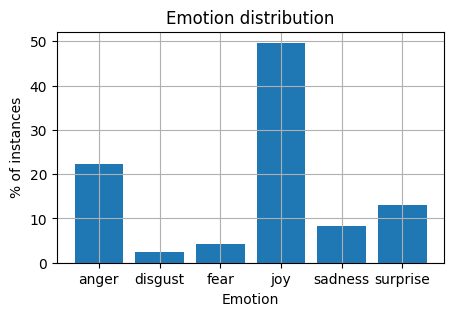

In [32]:
# Split data to train and test
train_df = df[df["split"] == "train"].dropna(subset=["emotion"])
test_df = df[df["split"] == "test"]

'''
# Save csv file
df.to_csv("df_arrange.csv", index=False)
train_df.to_csv("df_arrange_train.csv", index=False)
test_df.to_csv("df_arrange_test.csv", index=False)
'''
print("="*20,"df: Split count","="*20)
print("Split count:",df["split"].value_counts())
print("="*20,"df: Split proportion","="*20)
print("Split proportion:",df["split"].value_counts()/len(df))
print("="*20,"train df: Count of each label in train data","="*20)
print("Emotion count:",train_df["emotion"].value_counts())
print("="*20,"train df: Proportion of each label in train data","="*20)
print("Emotion proportion:",train_df["emotion"].value_counts()/len(train_df))

import numpy as np
import matplotlib.pyplot as plt

# Histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

# Plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

### <a id='toc1_1_4_'></a>[**1.1.4 Create Pseudo Train / Test Split Data**](#toc1_1_4_)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\data\task-emotion-recognition"

# Load data
train_df = pd.read_csv(f"{PATH}/df_arrange_train.csv")
test_df  = pd.read_csv(f"{PATH}/df_arrange_test.csv")   # official test, NO labels

# Create pseudo-train / pseudo-test from *labeled* train_df
train_df_pseudo, test_df_pseudo = train_test_split(
    train_df,
    test_size=0.25,                  # 25% of original train as pseudo-test; tweak if you like
    # stratify=train_df['emotion'],  # keep label distribution similar
    random_state=10000               # for reproducibility
)

In [37]:
print("="*20,"pseuso train df: Proportion of each label in train data","="*20)
print("Emotion proportion:",train_df_pseudo["emotion"].value_counts()/len(train_df_pseudo))
print("="*20,"pseuso test df: Proportion of each label in train data","="*20)
print("Emotion proportion:",test_df_pseudo["emotion"].value_counts()/len(test_df_pseudo))

==================== pseuso train df: Proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.496172
anger       0.222819
surprise    0.131331
sadness     0.081855
fear        0.042153
disgust     0.025670
Name: count, dtype: float64
==================== pseuso test df: Proportion of each label in train data ====================
Emotion proportion: emotion
joy         0.499123
anger       0.224756
surprise    0.130627
sadness     0.082352
fear        0.041343
disgust     0.021799
Name: count, dtype: float64


In [38]:
# Extract main text and its label
X_train_pseudo = train_df_pseudo['text']
y_train_pseudo = train_df_pseudo['emotion']
X_test_pseudo   = test_df_pseudo['text']
y_test_pseudo   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo.shape); print('y_train_pseudo.shape: ', y_train_pseudo.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo.shape)

X_train_pseudo.shape:  (35917,)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973,)
y_test_pseudo.shape:    (11973,)


### <a id='toc1_1_5_'></a>[**1.1.5 Useful Function**](#toc1_1_5_)

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

# ================================================================================================
# Evaluation: Overall Report and Confusion Matrix
# ================================================================================================
def plot_confusion_matrix(cm, classes, title='Confusion matrix', fmt = '.2f',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = fmt
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

def evaluate_classifier(y_train, y_train_pred, y_test, y_test_pred, class_names=None, title="Confusion Matrix", fmt = 'd'):
    """
    Evaluate classifier performance on train and test predictions.
    
    Parameters:
        y_train: true training labels
        y_train_pred: predicted training labels
        y_test: true test labels
        y_test_pred: predicted test labels
        class_names: list of class names for confusion matrix
        title: title for confusion matrix plot
    """
    
    # Accuracy
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    print(f"Training accuracy: {acc_train:.2f}")
    print(f"Testing accuracy: {acc_test:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
    
    # Confusion matrix
    # cm = confusion_matrix(y_test, y_test_pred)
    # plot_confusion_matrix(cm, classes=class_names, title=title, fmt = fmt)
    cm_tree_normalize = confusion_matrix(y_true=y_test, y_pred=y_test_pred, normalize='true') 
    plot_confusion_matrix(cm_tree_normalize, classes=class_names, title=title, fmt = '.2f')

# ================================================================================================
# Fix seed
# ================================================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
# ================================================================================================
# Evaluation: macro-F1
# ================================================================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

import pandas as pd

# ================================================================================================
# Result: Probability Result of Each Class
# ================================================================================================
def export_probability_dataframe(
        model, 
        X_train, X_test, 
        y_train_pred, y_test_pred,
        train_ids, test_ids,
        train_filename="df_train_output.csv",
        test_filename="df_test_output.csv"
    ):
    """
    Create probability prediction DataFrames for train & test,
    insert id + predicted label, and save to CSV.
    """

    # 1. Extract class names
    class_names = model.classes_

    # 2. Predict probabilities
    prob_train = model.predict_proba(X_train)
    prob_test = model.predict_proba(X_test)

    # 3. Build DataFrames
    df_train = pd.DataFrame(prob_train, columns=class_names)
    df_test = pd.DataFrame(prob_test, columns=class_names)

    # 4. Insert predicted label (first column)
    df_train.insert(0, "pred_label", y_train_pred)
    df_test.insert(0, "pred_label", y_test_pred)

    # 5. Insert ID (first column)
    df_train.insert(0, "id", train_ids)
    df_test.insert(0, "id", test_ids)

    # 6. Save to CSV
    df_train.to_csv(train_filename, index=False)
    df_test.to_csv(test_filename, index=False)

    print(f"Saved: {train_filename}")
    print(f"Saved: {test_filename}")

    return df_train, df_test


## <a id='toc1_2_'></a>[**1.2 Feature Engineering Steps**](#toc1_2_)
### <a id='toc1_2_1_'></a>[**1.2.1 Bag-of-Words**](#toc1_2_1_)

In [23]:
# ================================================================================================
# BOW 500
# ================================================================================================
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Build analyzers (bag-of-words)
BOW_500_psuedo = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# Apply analyzer to training data
BOW_500_psuedo.fit(train_df_pseudo['text'])
X_train_pseudo_BOW_500 = BOW_500_psuedo.transform(train_df_pseudo['text'])
y_train_pseudo_BOW_500 = train_df_pseudo['emotion']
X_test_pseudo_BOW_500   = BOW_500_psuedo.transform(test_df_pseudo['text'])
y_test_pseudo_BOW_500   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo_BOW_500.shape); print('y_train_pseudo.shape: ', y_train_pseudo_BOW_500.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo_BOW_500.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo_BOW_500.shape)

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X_train_pseudo.shape:  (35917, 500)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973, 500)
y_test_pseudo.shape:    (11973,)


### <a id='toc1_2_2_'></a>[**1.1.2 TF-IDF**](#toc1_2_2_)

In [24]:
# ================================================================================================
# TF-IDF 1000
# ================================================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Build analyzers (TF-IDF)
TFIDF_1000_psuedo = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
# (Optional) remove common stopwords (This changes result but I think it is more useful.)
# TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize, lowercase=True, stop_words='english')

# Apply analyzer to training data
TFIDF_1000_psuedo.fit(train_df_pseudo['text'])
X_train_pseudo_TFIDF_1000 = TFIDF_1000_psuedo.transform(train_df_pseudo['text'])
y_train_pseudo_TFIDF_1000 = train_df_pseudo['emotion']
X_test_pseudo_TFIDF_1000   = TFIDF_1000_psuedo.transform(test_df_pseudo['text'])
y_test_pseudo_TFIDF_1000   = test_df_pseudo['emotion']
# Check dimension
print('X_train_pseudo.shape: ', X_train_pseudo_TFIDF_1000.shape); print('y_train_pseudo.shape: ', y_train_pseudo_TFIDF_1000.shape)
print('X_test_pseudo.shape:   ', X_test_pseudo_TFIDF_1000.shape);   print('y_test_pseudo.shape:   ', y_test_pseudo_TFIDF_1000.shape)

X_train_pseudo.shape:  (35917, 1000)
y_train_pseudo.shape:  (35917,)
X_test_pseudo.shape:    (11973, 1000)
y_test_pseudo.shape:    (11973,)


## <a id='toc1_3_'></a>[**1.3 Model Implementation Steps**](#toc1_3_)
### <a id='toc1_3_1_'></a>[**1.3.1 Naive Bayes (ft. BOW 500)**](#toc1_3_1_)

In [26]:
# ================================================================================================
# Naive Bayes + BOW 500
# ================================================================================================
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

# Build the Naive Bayes model
model_NB_pseudo = MultinomialNB() 
model_NB_pseudo.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)                         # Train
y_train_pred_NB_pseudo = model_NB_pseudo.predict(X_train_pseudo_BOW_500)                    # Predict on train
y_test_pred_NB_pseudo = model_NB_pseudo.predict(X_test_pseudo_BOW_500)                      # Predict on test
prob_train_pred_NB_pseudo = model_NB_pseudo.predict_proba(X_train_pseudo_BOW_500)
prob_test_pred_NB_pseudo = model_NB_pseudo.predict_proba(X_test_pseudo_BOW_500)

# ================================================================================================
# Weighted Naive Bayes + BOW 500
# ================================================================================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare WEIGHT
classes = np.array(['joy','anger','surprise','sadness','fear','disgust'])
weights = compute_class_weight(class_weight='balanced',classes=classes,y=y_train_pseudo_BOW_500)
class_weights = dict(zip(classes, weights))
sample_weights = train_df_pseudo['emotion'].map(class_weights).values

# Build the Naive Bayes model with WEIGHT
model_NB_weight_pseudo = MultinomialNB() 
model_NB_weight_pseudo.partial_fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500, classes=classes, sample_weight=sample_weights)
y_train_pred_NB_weight_pseudo = model_NB_weight_pseudo.predict(X_train_pseudo_BOW_500)      # Predict on train
y_test_pred_NB_weight_pseudo = model_NB_weight_pseudo.predict(X_test_pseudo_BOW_500)        # Predict on test
prob_train_pred_NB_weight_pseudo = model_NB_calibrate.predict_proba(X_train_pseudo_BOW_500)
prob_test_pred_NB_weight_pseudo = model_NB_calibrate.predict_proba(X_test_pseudo_BOW_500)

# ================================================================================================
# Calibrated Naive Bayes + BOW 500
# ================================================================================================
# Build the Naive Bayes model with CALIBRATION
from sklearn.calibration import CalibratedClassifierCV
# Build the Naive Bayes model
model_NB_pseudo = MultinomialNB() 
model_NB_calibrate_pseudo = CalibratedClassifierCV(model_NB_pseudo, method="isotonic")
model_NB_calibrate_pseudo.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)
y_train_pred_NB_calibrate_pseudo = model_NB_calibrate_pseudo.predict(X_train_pseudo_BOW_500) # Predict on train
y_test_pred_NB_calibrate_pseudo = model_NB_calibrate_pseudo.predict(X_test_pseudo_BOW_500)   # Predict on test
prob_train_pred_NB_calibrate_pseudo = model_NB_calibrate_pseudo.predict_proba(X_train_pseudo_BOW_500)
prob_test_pred_NB_calibrate_pseudo = model_NB_calibrate_pseudo.predict_proba(X_test_pseudo_BOW_500)

### <a id='toc1_3_2_'></a>[**1.3.2 Decision-Tree (ft. BOW 500)**](#toc1_3_2_)

In [40]:
# ================================================================================================
#  Decision Tree + BOW 500
# ================================================================================================
from sklearn.tree import DecisionTreeClassifier

# Build DecisionTree model
model_DT_pseudo = DecisionTreeClassifier(random_state=1)
model_DT_pseudo = model_DT_pseudo.fit(X_train_pseudo_BOW_500, y_train_pseudo_BOW_500)        # Train
y_train_pred_DT_pseudo = model_DT_pseudo.predict(X_train_pseudo_BOW_500)                     # Predict on train
y_test_pred_DT_pseudo = model_DT_pseudo.predict(X_test_pseudo_BOW_500)                       # Predict on test

### <a id='toc1_3_3_'></a>[**1.3.3 Linear Support Vector Classifier (LinearSVC) (ft. TF-IDF)**](#toc1_3_3_)

In [28]:
# ================================================================================================
#  SVM + TF-IDF 1000
# ================================================================================================
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline


# Base model
base_svm = LinearSVC(class_weight="balanced", random_state=42)

# Calibrated model to enable probability output
model_SVM_pseudo = CalibratedClassifierCV(base_svm, method="sigmoid", cv=3)
model_SVM_pseudo.fit(X_train_pseudo_TFIDF_1000, y_train_pseudo_TFIDF_1000)
y_train_pred_SVM_pseudo = model_SVM_pseudo.predict(X_train_pseudo_TFIDF_1000)
y_test_pred_SVM_pseudo = model_SVM_pseudo.predict(X_test_pseudo_TFIDF_1000)
prob_train_pred_SVM_pseudo = model_SVM_pseudo.predict_proba(X_train_pseudo_TFIDF_1000)
prob_test_pred_SVM_pseudo = model_SVM_pseudo.predict_proba(X_test_pseudo_TFIDF_1000)

### <a id='toc1_3_4_'></a>[**1.3.4 DistilRoBERTa (ft. embeddings)**](#toc1_3_4_)

In [80]:
# ================================================================================================
# Extract Distilroberta Result
# ================================================================================================
import torch
import pandas as pd

def predict_with_probs(trainer, train_or_test_ds, train_or_test_df, id2label):
    """
    Run prediction with a HuggingFace Trainer model and return a dataframe
    containing predicted labels + per-class probabilities.

    Args:
        trainer : HuggingFace Trainer object
        test_ds : tokenized test Dataset
        test_df : original pandas dataframe (must align with test_ds order)
        id2label : dict mapping {class_id: label_string}

    Returns:
        DataFrame with columns:
            - pred_label
            - prob_<label_name> (one per class)
    """

    # 1. Predict
    train_or_test_pred = trainer.predict(train_or_test_ds)

    # 2. Extract logits → probability
    logits = train_or_test_pred.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    # 3. Argmax → predicted class id → label string
    pred_ids = probs.argmax(axis=1)
    pred_labels = [id2label[int(i)] for i in pred_ids]

    # 4. Build output dataframe
    out_df = train_or_test_df.copy()
    out_df["pred_label"] = pred_labels

    # 5. Add probability columns
    for class_id, class_name in id2label.items():
        out_df[f"prob_{class_name}"] = probs[:, class_id]

    return out_df

In [78]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 1. Build raw dataset from pandas
train_ds_pseudo = Dataset.from_dict({
    "text": train_df_pseudo["text"].tolist(),
    "labels": train_df_pseudo["emotion"].tolist()   # strings for now
})

test_ds_pseudo = Dataset.from_dict({
    "text": test_df_pseudo["text"].tolist(),
    "labels": test_df_pseudo["emotion"].tolist()
})

# 2. Map string labels → ints
label_list = sorted(train_df_pseudo["emotion"].unique())
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

def encode_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

train_ds_pseudo = train_ds_pseudo.map(encode_labels)
test_ds_pseudo  = test_ds_pseudo.map(encode_labels)

# 3. Tokenize text via .map
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=128
    )
train_ds_pseudo = train_ds_pseudo.map(tokenize_batch, batched=True)
test_ds_pseudo  = test_ds_pseudo.map(tokenize_batch, batched=True)

# 4. Drop raw text column (model doesn’t need it)
train_ds_pseudo = train_ds_pseudo.remove_columns(["text"])
test_ds_pseudo  = test_ds_pseudo.remove_columns(["text"])

# 5. Set format to PyTorch tensors
train_ds_pseudo.set_format(type="torch")
test_ds_pseudo.set_format(type="torch")

# 6. Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 7. Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 8. Training config
training_args = TrainingArguments(
    output_dir="./roberta_pseudo",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    fp16=False,  # True only if you have a GPU that supports it
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_pseudo,
    eval_dataset=test_ds_pseudo,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Map:   0%|          | 0/35917 [00:00<?, ? examples/s]

Map:   0%|          | 0/11973 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\chenw\AppData\Local\Temp\ipykernel_16276\824030335.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.452900
100,1.253600
150,1.140600
200,1.078900
250,1.086000
300,1.035400
350,1.011000
400,1.006800
450,1.024400
500,0.991500


TrainOutput(global_step=2245, training_loss=0.9730624702300685, metrics={'train_runtime': 446.8863, 'train_samples_per_second': 80.372, 'train_steps_per_second': 5.024, 'total_flos': 380067797476224.0, 'train_loss': 0.9730624702300685, 'epoch': 1.0})

In [81]:
df_train_distilroberta_base_pseudo = predict_with_probs(trainer=trainer,
                                                        train_or_test_ds=train_ds_pseudo,
                                                        train_or_test_df=train_df_pseudo,
                                                        id2label=id2label)
print(df_train_distilroberta_base_pseudo.shape)
df_train_distilroberta_base_pseudo.head(3)

(35917, 11)


,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
30795,0xa56ae4,"Well, that's just a distraction for the color ...",train,joy,joy,0.308613,0.022619,0.007722,0.347416,0.180887,0.132743
33523,0x0a62dd,That’s blasphemous 😩,train,anger,anger,0.524602,0.282274,0.019247,0.081113,0.064582,0.028184
2824,0xd0c564,I am sorry but what is a wholesome meme,train,surprise,sadness,0.058785,0.010704,0.005300,0.370372,0.442927,0.111911


In [82]:
df_test_distilroberta_base_pseudo = predict_with_probs(trainer=trainer,
                                                       train_or_test_ds=test_ds_pseudo,
                                                       train_or_test_df=test_df_pseudo,
                                                       id2label=id2label)
print(df_test_distilroberta_base_pseudo.shape)
df_test_distilroberta_base_pseudo.head(3)

(11973, 11)


,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
44140,0x19b50b,Finishing peeing and then still feeling like y...,train,joy,joy,0.172213,0.060447,0.121410,0.348192,0.247832,0.049907
46622,0x69e48c,Kill me.,train,joy,anger,0.770875,0.043310,0.059515,0.073289,0.034685,0.018326
19832,0x0c0183,I feel bad for these guys. I'd like to be able...,train,disgust,sadness,0.073448,0.048173,0.030596,0.166611,0.664418,0.016754


In [84]:
'''
# Save results
df_train_distilroberta_base_pseudo.to_csv("df_train_distilroberta_base_pseudo.csv", index=False)
df_test_distilroberta_base_pseudo.to_csv("df_test_distilroberta_base_pseudo.csv", index=False)
'''

In [87]:
# Load results
import pandas as pd

result_PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\results\task-emotion-recognition"
df_train_distilroberta_base_pseudo = pd.read_csv(f"{result_PATH}/df_train_distilroberta_base_pseudo.csv")
df_test_distilroberta_base = pd.read_csv(f"{result_PATH}/df_test_distilroberta_base_pseudo.csv")
y_train_pred_distilroberta_base = df_train_distilroberta_base_pseudo["pred_label"].to_numpy()
y_test_pred_distilroberta_base = df_test_distilroberta_base["pred_label"].to_numpy()
df_test_distilroberta_base.head(3)

,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
0,0x19b50b,Finishing peeing and then still feeling like y...,train,joy,joy,0.172213,0.060447,0.121410,0.348192,0.247832,0.049907
1,0x69e48c,Kill me.,train,joy,anger,0.770875,0.043310,0.059515,0.073289,0.034685,0.018326
2,0x0c0183,I feel bad for these guys. I'd like to be able...,train,disgust,sadness,0.073448,0.048173,0.030596,0.166611,0.664418,0.016754


# <a id='toc2_'></a>[**2. Bonus Section**](#toc1_)
## <a id='toc2_1_'></a>[**2.1 Try and Evaluate Different Models**](#toc2_1_)
## <a id='toc2_2_'></a>[**2.2 Insight Gained**](#toc2_2_)

Training accuracy: 0.58
Testing accuracy: 0.57

Classification Report:
               precision    recall  f1-score   support

       anger       0.48      0.42      0.45      2691
     disgust       0.07      0.03      0.05       261
        fear       0.25      0.26      0.26       495
         joy       0.66      0.79      0.72      5976
     sadness       0.42      0.19      0.27       986
    surprise       0.50      0.47      0.48      1564

    accuracy                           0.57     11973
   macro avg       0.40      0.36      0.37     11973
weighted avg       0.55      0.57      0.56     11973



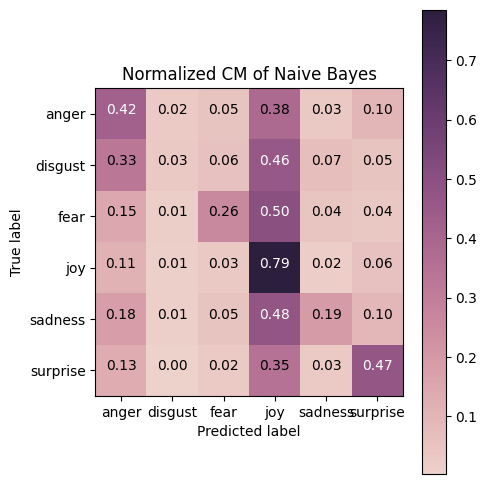

Training accuracy: 0.45
Testing accuracy: 0.43

Classification Report:
               precision    recall  f1-score   support

       anger       0.46      0.28      0.35      2691
     disgust       0.06      0.33      0.10       261
        fear       0.14      0.50      0.22       495
         joy       0.83      0.48      0.61      5976
     sadness       0.23      0.34      0.28       986
    surprise       0.38      0.56      0.46      1564

    accuracy                           0.43     11973
   macro avg       0.35      0.42      0.34     11973
weighted avg       0.59      0.43      0.48     11973



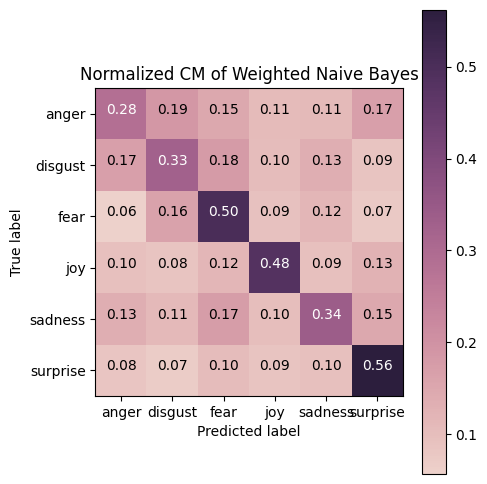

Training accuracy: 0.59
Testing accuracy: 0.58

Classification Report:
               precision    recall  f1-score   support

       anger       0.49      0.42      0.45      2691
     disgust       0.00      0.00      0.00       261
        fear       0.38      0.15      0.22       495
         joy       0.63      0.83      0.72      5976
     sadness       0.48      0.16      0.24       986
    surprise       0.53      0.41      0.46      1564

    accuracy                           0.58     11973
   macro avg       0.42      0.33      0.35     11973
weighted avg       0.55      0.58      0.55     11973



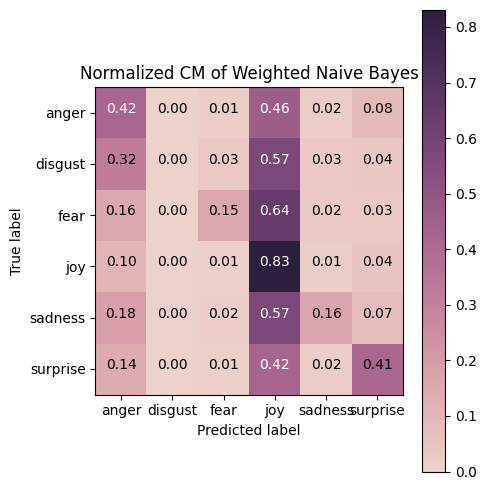

Training accuracy: 0.99
Testing accuracy: 0.48

Classification Report:
               precision    recall  f1-score   support

       anger       0.37      0.39      0.38      2691
     disgust       0.04      0.05      0.04       261
        fear       0.18      0.16      0.17       495
         joy       0.65      0.65      0.65      5976
     sadness       0.23      0.20      0.21       986
    surprise       0.36      0.36      0.36      1564

    accuracy                           0.48     11973
   macro avg       0.31      0.30      0.30     11973
weighted avg       0.48      0.48      0.48     11973



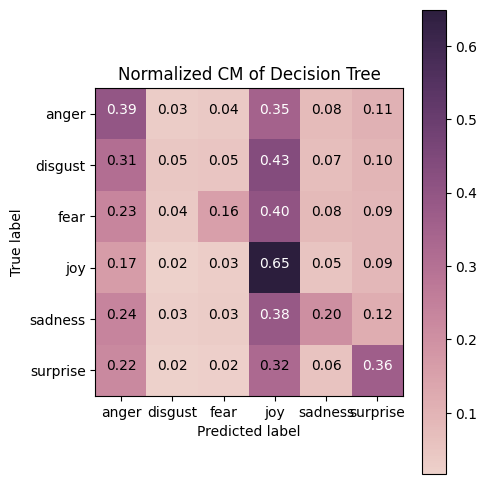

Training accuracy: 0.64
Testing accuracy: 0.62

Classification Report:
               precision    recall  f1-score   support

       anger       0.55      0.47      0.51      2691
     disgust       0.62      0.04      0.07       261
        fear       0.57      0.21      0.31       495
         joy       0.64      0.87      0.74      5976
     sadness       0.56      0.20      0.29       986
    surprise       0.59      0.38      0.46      1564

    accuracy                           0.62     11973
   macro avg       0.59      0.36      0.40     11973
weighted avg       0.61      0.62      0.58     11973



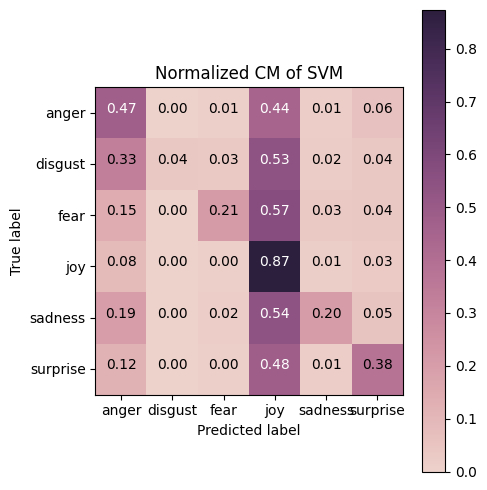

Training accuracy: 0.71
Testing accuracy: 0.68

Classification Report:
               precision    recall  f1-score   support

       anger       0.59      0.64      0.62      2691
     disgust       0.27      0.05      0.08       261
        fear       0.51      0.54      0.52       495
         joy       0.78      0.83      0.81      5976
     sadness       0.50      0.37      0.43       986
    surprise       0.62      0.54      0.57      1564

    accuracy                           0.68     11973
   macro avg       0.54      0.50      0.50     11973
weighted avg       0.67      0.68      0.67     11973



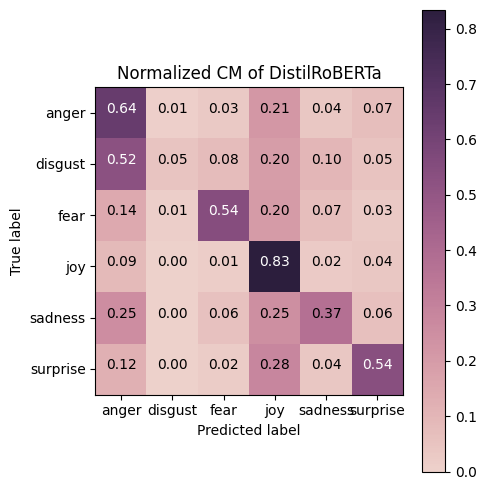

In [43]:
#  Evaluation
class_names = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
evaluate_classifier(y_train_pseudo, y_train_pred_NB_pseudo, y_test_pseudo, y_test_pred_NB_pseudo, class_names=class_names, title="Normalized CM of Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_NB_weight_pseudo, y_test_pseudo, y_test_pred_NB_weight_pseudo, class_names=class_names, title="Normalized CM of Weighted Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_NB_calibrate_pseudo, y_test_pseudo, y_test_pred_NB_calibrate_pseudo, class_names=class_names, title="Normalized CM of Calibrated Naive Bayes")
evaluate_classifier(y_train_pseudo, y_train_pred_DT_pseudo, y_test_pseudo, y_test_pred_DT_pseudo, class_names=class_names, title="Normalized CM of Decision Tree")
evaluate_classifier(y_train_pseudo, y_train_pred_SVM_pseudo, y_test_pseudo, y_test_pred_SVM_pseudo, class_names=class_names, title="Normalized CM of SVM")
evaluate_classifier(y_train_pseudo, y_train_pred_distilroberta_base_pseudo, y_test_pseudo, y_test_pred_distilroberta_base_pseudo, class_names=class_names, title="Normalized CM of DistilRoBERTa")

In [80]:
# ================================================================================================
# Ensemble Model: If DistilRoBERTa not sure ask other model!
# ================================================================================================
import numpy as np
import pandas as pd

def ensemble_fallback(
        proba_main,              # main model probabilities (e.g., RoBERTa)
        proba_fallback,          # fallback model probabilities (NB / CNB / SVM)
        tau=0.6,                 # confidence threshold
        main_classes=None,       # list of class names (main model)
        fallback_classes=None,   # list of class names (fallback model)
        output_as_label=True     # final output in label names or indices
    ):
    """
    Ensemble logic:
    - If main model (e.g., DistilRoBERTa) max probability >= tau → use main model.
    - Otherwise fallback to NB / CNB / SVM.
    
    Also prints how many predictions used fallback.
    """

    # 1. Main model confidence & predictions
    max_proba_main = proba_main.max(axis=1)
    pred_main_idx = proba_main.argmax(axis=1)

    # 2. Fallback model predictions
    pred_fallback_idx = proba_fallback.argmax(axis=1)

    # 3. Align fallback classes to main class order if needed
    if main_classes is not None and fallback_classes is not None:
        f2i = {cls: i for i, cls in enumerate(fallback_classes)}
        m2i = {cls: i for i, cls in enumerate(main_classes)}

        aligned_fallback = []
        for idx in pred_fallback_idx:
            cls = fallback_classes[idx]
            aligned_fallback.append(m2i[cls])
        pred_fallback_idx = np.array(aligned_fallback)

    # 4. Decide which model to use per sample
    use_main = max_proba_main >= tau
    final_idx = np.where(use_main, pred_main_idx, pred_fallback_idx)

    # 5. Convert to class labels
    if output_as_label and main_classes is not None:
        final_labels = np.array([main_classes[i] for i in final_idx])
    else:
        final_labels = final_idx

    # 6. Statistics
    total = len(final_idx)
    used_main = use_main.sum()
    used_fallback = total - used_main

    print('='*20,"Ensemble Decision Summary",'='*20)
    print(f"Threshold (tau): {tau}")
    print(f"Total samples: {total}")
    print(f"Predicted by RoBERTa (confident): {used_main}  ({used_main/total:.2%})")
    print(f"Fallback model used:             {used_fallback}  ({used_fallback/total:.2%})")
    print('='*67,"\n")

    return final_labels

In [49]:
df_train_distilroberta_base_pseudo = pd.read_csv(f"{result_PATH}/df_train_distilroberta_base_pseudo.csv")
df_test_distilroberta_base_pseudo = pd.read_csv(f"{result_PATH}/df_test_distilroberta_base_pseudo.csv")
df_train_distilroberta_base_pseudo = df_train_distilroberta_base_pseudo.rename(
    columns=lambda c: c.replace("prob_", "")
)
df_test_distilroberta_base_pseudo = df_test_distilroberta_base_pseudo.rename(
    columns=lambda c: c.replace("prob_", "")
)
y_train_pred_distilroberta_base_pseudo = df_train_distilroberta_base_pseudo["pred_label"].to_numpy()
y_test_pred_distilroberta_base_pseudo = df_test_distilroberta_base_pseudo["pred_label"].to_numpy()
exclude_cols = ["id", "text", "split", "emotion", "pred_label"]
class_roberta_base = [c for c in df_train_distilroberta_base_pseudo.columns if c not in exclude_cols]
prob_train_pred_distilroberta_pseudo = df_train_distilroberta_base_pseudo[class_roberta_base].to_numpy()
prob_test_pred_distilroberta_pseudo = df_test_distilroberta_base_pseudo[class_roberta_base].to_numpy()
# 檢查一下兩邊的 class 是否相同（順序可以不同）
classes_NB_weight = model_NB_weight_pseudo.classes_
classes_NB_calibrate = model_NB_calibrate_pseudo.classes_
classes_SVM = model_SVM_pseudo.classes_
print("Detected Weighted Naive Bayes class columns:", classes_NB_weight)
print("Detected Calibrated Naive Bayes class columns:", classes_NB_calibrate)
print("Detected SVM class columns:", classes_SVM)
print("Detected DistilRoBERTa class columns:", class_roberta_base)

Detected Weighted Naive Bayes class columns: ['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']
Detected Calibrated Naive Bayes class columns: ['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']
Detected SVM class columns: ['anger' 'disgust' 'fear' 'joy' 'sadness' 'surprise']
Detected DistilRoBERTa class columns: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


In [93]:
y_train_pred_final_pseudo = ensemble_fallback(
    proba_main=prob_train_pred_distilroberta_pseudo,
    proba_fallback=prob_train_pred_NB_weight_pseudo,
    tau=0.50,
    main_classes=class_roberta_base,
    fallback_classes=classes_NB_weight
)
print(accuracy_score(y_train_pseudo, y_train_pred_final_pseudo))

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.5
Total samples: 35917
Predicted by RoBERTa (confident): 28440  (79.18%)
Fallback model used:             7477  (20.82%)

0.6839101261241195


In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def sweep_tau(
    tau_list,
    proba_train_main, proba_train_fallback,
    proba_test_main,  proba_test_fallback,
    y_train_true, y_test_true,
    main_classes, fallback_classes
):
    results = []

    for tau in tau_list:
        # Train prediction
        y_train_pred = ensemble_fallback(
            proba_main=proba_train_main,
            proba_fallback=proba_train_fallback,
            tau=tau,
            main_classes=main_classes,
            fallback_classes=fallback_classes,
            output_as_label=True
        )

        # Test prediction
        y_test_pred = ensemble_fallback(
            proba_main=proba_test_main,
            proba_fallback=proba_test_fallback,
            tau=tau,
            main_classes=main_classes,
            fallback_classes=fallback_classes,
            output_as_label=True
        )

        # Compute accuracy
        train_acc = accuracy_score(y_train_true, y_train_pred)
        test_acc  = accuracy_score(y_test_true,  y_test_pred)

        results.append({
            "tau": tau,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        })

    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [100]:
tau_values = np.linspace(0.20, 0.50, 7)  

df_tau_results = sweep_tau(
    tau_list=tau_values,
    proba_train_main=prob_train_pred_distilroberta_pseudo,
    proba_train_fallback=prob_train_pred_SVM_pseudo,
    proba_test_main=prob_test_pred_distilroberta_pseudo,
    proba_test_fallback=prob_test_pred_SVM_pseudo,
    y_train_true=y_train_pseudo,
    y_test_true=y_test_pseudo,
    main_classes=class_roberta_base,
    fallback_classes=classes_NB_calibrate
)

print(df_tau_results)

'''
No matter weighted NB, linear SVC or other model, all of them are to simple (using underrepresent features).
Thus it is not able to use them to improve accuracy by referencing their result and use in DistilRoBERTa result.
'''

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.2
Total samples: 35917
Predicted by RoBERTa (confident): 35917  (100.00%)
Fallback model used:             0  (0.00%)

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.2
Total samples: 11973
Predicted by RoBERTa (confident): 11973  (100.00%)
Fallback model used:             0  (0.00%)

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.25
Total samples: 35917
Predicted by RoBERTa (confident): 35859  (99.84%)
Fallback model used:             58  (0.16%)

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.25
Total samples: 11973
Predicted by RoBERTa (confident): 11954  (99.84%)
Fallback model used:             19  (0.16%)

==================== Ensemble Decision Summary ====================
Threshold (tau): 0.3
Total samples: 35917
Predicted by RoBERTa (confident): 35478  (98.78%)
Fallback model

'\nNo matter weighted NB, linear SVC or other model, all of them are to simple (using underrepresent features).\nThus it is not able to use them to improve accuracy by referencing their result and use in DistilRoBERTa result.\n'

In [99]:
idx_disgust = class_roberta_base.index("disgust")
mask_disgust = (y_train_pred_NB_weight_pseudo == "disgust")
y_train_pred_final_pseudo = y_train_pred_distilroberta_base_pseudo.copy()
y_train_pred_final_pseudo[mask_disgust] = "disgust"
print(accuracy_score(y_train_pseudo, y_train_pred_distilroberta_base_pseudo))
print(accuracy_score(y_train_pseudo, y_train_pred_pseudo_final))

'''
Use weighted NB to improve class "disgust" is not enough to improve performance
'''

0.7100537350001392
0.6839101261241195


'\nUse weighted NB to improve class "disgust" is not enough to improve performance\n'

# <a id='toc3_'></a>[**3. Model Implementation on Full Data**](#toc3_)

In [19]:
# ================================================================================================
# BOW 500
# ================================================================================================
# Vectorize
from sklearn.feature_extraction.text import CountVectorizer
import nltk

# Build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# Apply analyzer to training data
BOW_500.fit(train_df['text'])
X_train_BOW_500 = BOW_500.transform(train_df['text'])
y_train_BOW_500 = train_df['emotion']
X_test_BOW_500   = BOW_500.transform(test_df['text'])
y_test_BOW_500   = test_df['emotion']

C:\Users\chenw\anaconda3\envs\dm2025\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
# ================================================================================================
# TF-IDF 1000
# ================================================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Build analyzers (TF-IDF)
TFIDF_1000_psuedo = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
# (Optional) remove common stopwords (This changes result but I think it is more useful.)
# TFIDF_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize, lowercase=True, stop_words='english')

# Apply analyzer to training data
TFIDF_1000_psuedo.fit(train_df['text'])
X_train_TFIDF_1000 = TFIDF_1000_psuedo.transform(train_df['text'])
y_train_TFIDF_1000 = train_df['emotion']
X_test_TFIDF_1000   = TFIDF_1000_psuedo.transform(test_df['text'])
y_test_TFIDF_1000   = test_df['emotion']

In [11]:
# ================================================================================================
# Naive Bayes + BOW 500
# ================================================================================================
import pandas as pd
from sklearn.naive_bayes import MultinomialNB

# Build the Naive Bayes model
model_NB = MultinomialNB() 
model_NB.fit(X_train_BOW_500, y_train_BOW_500)                         # Train
y_train_pred_NB = model_NB.predict(X_train_BOW_500)                    # Predict on train
y_test_pred_NB = model_NB.predict(X_test_BOW_500)                      # Predict on test

# Save results
submission = pd.DataFrame({
  "id": test_df["id"],
  "emotion": y_test_pred_NB
})
submission.to_csv("df_submission_nb.csv", index=False)

# Extract probability
prob_train_pred_NB = model_NB.predict_proba(X_train_BOW_500)
prob_test_pred_NB = model_NB.predict_proba(X_test_BOW_500)

# Organize dataFrame
class_NB = model_NB.classes_ 
df_train_NB = pd.DataFrame(prob_train_pred_NB, columns=class_NB)
df_test_NB = pd.DataFrame(prob_test_pred_NB, columns=class_NB)

# Insert pred_label（放第一欄）
df_train_NB.insert(0, "pred_label", y_train_pred_NB)
df_test_NB.insert(0, "pred_label", y_test_pred_NB)

# Insert id（放第一欄）
df_train_NB.insert(0, "id", train_df["id"].values)
df_test_NB.insert(0, "id", test_df["id"].values)
print(df_train_NB.head(3))

# Save outputs
df_train_NB.to_csv("df_train_nb.csv", index=False)
df_test_NB.to_csv("df_test_nb.csv", index=False)

# ================================================================================================
# Weighted Naive Bayes + BOW 500
# ================================================================================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Prepare WEIGHT
classes = np.array(['joy','anger','surprise','sadness','fear','disgust'])
weights = compute_class_weight(class_weight='balanced',classes=classes,y=y_train_BOW_500)
class_weights = dict(zip(classes, weights))
sample_weights = train_df['emotion'].map(class_weights).values

# Build the Naive Bayes model with WEIGHT
model_NB_weight = MultinomialNB() 
model_NB_weight.partial_fit(X_train_BOW_500, y_train_BOW_500, classes=classes, sample_weight=sample_weights)
y_train_pred_NB_weight = model_NB_weight.predict(X_train_BOW_500)      # Predict on train
y_test_pred_NB_weight = model_NB_weight.predict(X_test_BOW_500)        # Predict on test

# Save results
submission = pd.DataFrame({
  "id": test_df["id"],
  "emotion": y_test_pred_NB_weight
})
submission.to_csv("df_submission_nb_weight.csv", index=False)

# Extract probability
prob_train_pred_NB_weight = model_NB_weight.predict_proba(X_train_BOW_500)
prob_test_pred_NB_weight = model_NB_weight.predict_proba(X_test_BOW_500)

# Organize dataFrame
class_NB_weight = model_NB_weight.classes_ 
df_train_NB_weight = pd.DataFrame(prob_train_pred_NB_weight, columns=class_NB_weight)
df_test_NB_weight = pd.DataFrame(prob_test_pred_NB_weight, columns=class_NB_weight)

# Insert pred_label（放第一欄）
df_train_NB_weight.insert(0, "pred_label", y_train_pred_NB_weight)
df_test_NB_weight.insert(0, "pred_label", y_test_pred_NB_weight)

# Insert id（放第一欄）
df_train_NB_weight.insert(0, "id", train_df["id"].values)
df_test_NB_weight.insert(0, "id", test_df["id"].values)
print(df_train_NB_weight.head(3))

# Save outputs
df_train_NB_weight.to_csv("df_train_nb_weight.csv", index=False)
df_test_NB_weight.to_csv("df_test_nb_weight.csv", index=False)

# ================================================================================================
# Calibrated Naive Bayes + BOW 500
# ================================================================================================
# Build the Naive Bayes model with CALIBRATION
from sklearn.calibration import CalibratedClassifierCV
# Build the Naive Bayes model
model_NB = MultinomialNB() 
model_NB_calibrate = CalibratedClassifierCV(model_NB, method="isotonic")
model_NB_calibrate.fit(X_train_BOW_500, y_train_BOW_500)
y_train_pred_NB_calibrate = model_NB_calibrate.predict(X_train_BOW_500) # Predict on train
y_test_pred_NB_calibrate = model_NB_calibrate.predict(X_test_BOW_500)   # Predict on test

# Build the Naive Bayes model with CALIBRATION
from sklearn.calibration import CalibratedClassifierCV

# Build the Naive Bayes model
model_NB = MultinomialNB() 
model_NB_calibrate = CalibratedClassifierCV(model_NB, method="isotonic")
model_NB_calibrate.fit(X_train_BOW_500, y_train_BOW_500)
y_train_pred_NB_calibrate = model_NB_calibrate.predict(X_train_BOW_500)            # Predict on train
y_test_pred_NB_calibrate = model_NB_calibrate.predict(X_test_BOW_500)              # Predict on test

# Save results
submission = pd.DataFrame({
  "id": test_df["id"],
  "emotion": y_test_pred_NB_calibrate
})
submission.to_csv("df_submission_nb_calibrate.csv", index=False)

# Extract probability
prob_train_pred_NB_calibrate = model_NB_calibrate.predict_proba(X_train_BOW_500)
prob_test_pred_NB_calibrate = model_NB_calibrate.predict_proba(X_test_BOW_500)

# Organize dataFrame
class_NB_calibrate = model_NB_calibrate.classes_ 
df_train_NB_calibrate = pd.DataFrame(prob_train_pred_NB_calibrate, columns=class_NB_calibrate)
df_test_NB_calibrate = pd.DataFrame(prob_test_pred_NB_calibrate, columns=class_NB_calibrate)

# Insert pred_label（放第一欄）
df_train_NB_calibrate.insert(0, "pred_label", y_train_pred_NB_calibrate)
df_test_NB_calibrate.insert(0, "pred_label", y_test_pred_NB_calibrate)

# Insert id（放第一欄）
df_train_NB_calibrate.insert(0, "id", train_df["id"].values)
df_test_NB_calibrate.insert(0, "id", test_df["id"].values)
print(df_train_NB_calibrate.head(3))

# Save outputs
df_train_NB_calibrate.to_csv("df_train_nb_calibrate.csv", index=False)
df_test_NB_calibrate.to_csv("df_test_nb_calibrate.csv", index=False)

         id pred_label     anger   disgust      fear       joy   sadness  \
0  0x35663e   surprise  0.151064  0.017026  0.030278  0.191219  0.081513   
1  0xc78afe        joy  0.156570  0.031838  0.123650  0.414549  0.183280   
2  0x90089c   surprise  0.055138  0.026339  0.219040  0.064185  0.313519   

   surprise  
0  0.528900  
1  0.090113  
2  0.321779  
         id pred_label     anger   disgust      fear       joy   sadness  \
0  0x35663e   surprise  0.087978  0.100157  0.098817  0.049698  0.132646   
1  0xc78afe       fear  0.080706  0.144253  0.342971  0.096437  0.257040   
2  0x90089c       fear  0.020969  0.063732  0.389851  0.011441  0.309821   

   surprise  
0  0.530703  
1  0.078593  
2  0.204187  
         id pred_label     anger   disgust      fear       joy   sadness  \
0  0x35663e   surprise  0.176669  0.021650  0.037228  0.258346  0.079579   
1  0xc78afe        joy  0.202640  0.035029  0.087986  0.433998  0.146409   
2  0x90089c   surprise  0.120344  0.031953  0.1278

In [10]:
# ================================================================================================
#  Decision Tree + BOW 500
# ================================================================================================
from sklearn.tree import DecisionTreeClassifier

# Build DecisionTree model
model_DT = DecisionTreeClassifier(random_state=1)
model_DT = model_DT.fit(X_train_BOW_500, y_train_BOW_500)        # Train
y_train_pred_DT = model_DT.predict(X_train_BOW_500)                     # Predict on train
y_test_pred_DT = model_DT.predict(X_test_BOW_500)                       # Predict on test

# Save results
submission = pd.DataFrame({
  "id": test_df["id"],
  "emotion": y_test_pred_DT
})
submission.to_csv("df_submission_DT.csv", index=False)

In [12]:
# ================================================================================================
#  SVM + TF-IDF 1000
# ================================================================================================
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

# Build SVM model
model_SVM = LinearSVC(class_weight="balanced", random_state=42)
model_SVM.fit(X_train_TFIDF_1000, y_train_TFIDF_1000)
y_train_pred_SVM = model_SVM.predict(X_train_TFIDF_1000)            # Predict on train
y_test_pred_SVM = model_SVM.predict(X_test_TFIDF_1000)              # Predict on test

# Save results
submission = pd.DataFrame({
  "id": test_df["id"],
  "emotion": y_test_pred_DT
})
submission.to_csv("df_submission_LinearSVC.csv", index=False)

In [9]:
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 1. Build raw dataset from pandas
train_ds_full = Dataset.from_dict({
    "text": train_df["text"].tolist(),
    "labels": train_df["emotion"].tolist()   # still strings here
})

# 2. Map string labels → ints
label_list = sorted(train_df["emotion"].unique())
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

def encode_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

train_ds_full = train_ds_full.map(encode_labels)

# 3. Tokenize text via .map
def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=128
    )
train_ds_full = train_ds_full.map(tokenize_batch, batched=True)

# 4. Drop raw text column (model doesn’t need it)
train_ds_full = train_ds_full.remove_columns(["text"])

# 5. Set format to PyTorch tensors
train_ds_full.set_format(type="torch")

# 6. Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# 7. Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 8. Training config
training_args = TrainingArguments(
    output_dir="./roberta_final",
    per_device_train_batch_size=16,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    fp16=False,  # True only if you have a GPU that supports it
)

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_full,
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer.train()

Map:   0%|          | 0/47890 [00:00<?, ? examples/s]

Map:   0%|          | 0/47890 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\chenw\AppData\Local\Temp\ipykernel_28348\1937009319.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.409500
100,1.184100
150,1.094800
200,1.135700
250,1.065500
300,1.081100
350,1.080400
400,1.064200
450,0.972400
500,0.943900


TrainOutput(global_step=2994, training_loss=0.946748183103267, metrics={'train_runtime': 512.7014, 'train_samples_per_second': 93.407, 'train_steps_per_second': 5.84, 'total_flos': 509036596567272.0, 'train_loss': 0.946748183103267, 'epoch': 1.0})

In [15]:
df_train_distilroberta_base = predict_with_probs(trainer=trainer,
                                                 train_or_test_ds=train_ds_full,
                                                 train_or_test_df=train_df,
                                                 id2label=id2label)
print(df_train_distilroberta_base.shape)
print(df_train_distilroberta_base.head(3))

(47890, 11)
         id                                               text  split emotion  \
0  0x35663e  I bet there is an army of married couples who ...  train     joy   
1  0xc78afe                         This could only end badly.  train    fear   
2  0x90089c  My sister squeezed a lime in her milk when she...  train     joy   

  pred_label  prob_anger  prob_disgust  prob_fear  prob_joy  prob_sadness  \
0        joy    0.054338      0.004072   0.004988  0.684207      0.021337   
1    sadness    0.124307      0.041599   0.292295  0.061130      0.464652   
2        joy    0.153365      0.008450   0.021678  0.393913      0.202766   

   prob_surprise  
0       0.231057  
1       0.016017  
2       0.219828  


In [16]:
test_ds_real = Dataset.from_dict({
    "text": test_df["text"].tolist()  # <-- real test_df with NO emotion column
})
test_ds_real = test_ds_real.map(tokenize_batch, batched=True)
test_ds_real = test_ds_real.remove_columns(["text"])
test_ds_real.set_format("torch")

df_test_distilroberta_base = predict_with_probs(trainer=trainer,
                                                train_or_test_ds=test_ds_real,
                                                train_or_test_df=test_df,
                                                id2label=id2label)
print(df_test_distilroberta_base.shape)
print(df_test_distilroberta_base.head(3))

Map:   0%|          | 0/16281 [00:00<?, ? examples/s]

(16281, 11)
         id                                               text split  emotion  \
0  0x61fc95  We got the ranch, loaded our guns and sat up t...  test      NaN   
1  0xaba820         and that got my head bobbing a little bit.  test      NaN   
2  0x66e44d                Same. Glad it's not just out store.  test      NaN   

  pred_label  prob_anger  prob_disgust  prob_fear  prob_joy  prob_sadness  \
0        joy    0.172318      0.020356   0.220350  0.520464      0.024536   
1       fear    0.069748      0.025991   0.661169  0.137312      0.046896   
2        joy    0.009044      0.001092   0.001357  0.970986      0.006422   

   prob_surprise  
0       0.041977  
1       0.058884  
2       0.011099  


In [83]:
'''
# Save results
df_train_distilroberta_base.to_csv("df_train_distilroberta_base.csv", index=False)
df_test_distilroberta_base.to_csv("df_test_distilroberta_base.csv", index=False)
'''

'\n# Save results\ndf_train_distilroberta_base.to_csv("df_train_distilroberta_base.csv", index=False)\ndf_test_distilroberta_base.to_csv("df_test_distilroberta_base.csv", index=False)\n'

In [10]:
# Load results
import pandas as pd

result_PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\results\task-emotion-recognition"
df_test_distilroberta_base = pd.read_csv(f"{result_PATH}/df_test_distilroberta_base.csv")
df_test_distilroberta_base.head(3)

,id,text,split,emotion,pred_label,prob_anger,prob_disgust,prob_fear,prob_joy,prob_sadness,prob_surprise
0,0x61fc95,"We got the ranch, loaded our guns and sat up t...",test,NaN,joy,0.172318,0.020356,0.220350,0.520464,0.024536,0.041977
1,0xaba820,and that got my head bobbing a little bit.,test,NaN,fear,0.069748,0.025991,0.661169,0.137312,0.046896,0.058884
2,0x66e44d,Same. Glad it's not just out store.,test,NaN,joy,0.009044,0.001092,0.001357,0.970986,0.006422,0.011099


In [12]:
# Load results
submission_distilroberta_base = pd.DataFrame({
    "id": df_test_distilroberta_base["id"],          # or test_df["id"] if same order
    "emotion": df_test_distilroberta_base["pred_label"]
})
print(submission_distilroberta_base)
submission_distilroberta_base.to_csv("df_submission_distilroberta_base.csv", index=False)

             id emotion
0      0x61fc95     joy
1      0xaba820    fear
2      0x66e44d     joy
3      0xc03cf5     joy
4      0x02f65a   anger
...         ...     ...
16276  0x0f273c     joy
16277  0xfc4c5d   anger
16278  0xb318a3   anger
16279  0x8f758e    fear
16280  0x3a9174     joy

[16281 rows x 2 columns]


In [18]:
result_PATH = r"C:\Users\chenw\Class_DataMining\DM2025Labs\DM2025-Lab2-Exercise\results\task-emotion-recognition"

df_train_NB_calibrate = pd.read_csv(f"{result_PATH}/df_train_nb_calibrate.csv")
df_test_NB_calibrate = pd.read_csv(f"{result_PATH}/df_test_nb_calibrate.csv")
y_train_pred_NB_calibrate = df_train_NB_calibrate["pred_label"].to_numpy()
y_test_pred_NB_calibrate = df_test_NB_calibrate["pred_label"].to_numpy()
prob_train_pred_NB_calibrate = df_train_NB_calibrate.values   # shape: (n, n_classes)
prob_test_pred_NB_calibrate = df_test_NB_calibrate.values   # shape: (n, n_classes)

df_train_distilroberta_base = pd.read_csv(f"{result_PATH}/df_train_distilroberta_base.csv")
df_test_distilroberta_base = pd.read_csv(f"{result_PATH}/df_test_distilroberta_base.csv")
y_train_pred_distilroberta_base = df_train_distilroberta_base["pred_label"].to_numpy()
y_test_pred_distilroberta_base = df_test_distilroberta_base["pred_label"].to_numpy()
prob_train_pred_distilroberta = df_train_distilroberta_base.values
prob_test_pred_distilroberta = df_train_distilroberta_base.values

# 檢查一下兩邊的 class 是否相同（順序可以不同）
exclude_cols = ["id", "text", "split", "emotion", "pred_label"]
class_NB = [c for c in df_train_NB_calibrate.columns if c not in exclude_cols]
class_roberta_base = [c for c in df_train_distilroberta_base.columns if c not in exclude_cols]
print("Detected Naive Bayes class columns:", class_NB)
print("Detected DistilRoBERTa class columns:", class_roberta_base)

Detected Naive Bayes class columns: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
Detected DistilRoBERTa class columns: ['prob_anger', 'prob_disgust', 'prob_fear', 'prob_joy', 'prob_sadness', 'prob_surprise']


In [ ]:
# 檢查一下兩邊的 class 是否相同（順序可以不同）
exclude_cols = ["id", "text", "split", "emotion", "pred_label"]
class_NB = [c for c in df_train_NB_calibrate.columns if c not in exclude_cols]
class_roberta_base = [c for c in df_train_distilroberta_base.columns if c not in exclude_cols]
print("Detected Naive Bayes class columns:", class_NB)
print("Detected DistilRoBERTa class columns:", class_roberta_base)
import numpy as np

# 1. RoBERTa 的最大機率 + argmax
max_proba = proba_roberta.max(axis=1)          # shape (n,)
pred_roberta = proba_roberta.argmax(axis=1)    # shape (n,)

# 2. 第二模型（Naive Bayes）的 argmax
pred_nb = proba_nb.argmax(axis=1)              # shape (n,)

# 3. 設計一個門檻 tau
tau = 0.6  # 這個要在 validation set 上 tune

# 4. 最終預測：有信心用 RoBERTa，沒信心就交給 NB
final_pred = []
for i in range(len(max_proba)):
    if max_proba[i] >= tau:
        final_pred.append(pred_roberta[i])
    else:
        final_pred.append(pred_nb[i])

final_pred = np.array(final_pred)